# Imports

In [1]:
import torch
import torch.autograd as autograd
from multi_cmd import potentials, cmd_utils 

import matplotlib.pyplot as plt

# Testing Meta-Matrix Product

## Two Player Case

In [2]:
x_param = torch.tensor([1.0, 1.0], requires_grad=True)
y_param = torch.tensor([1.0, 1.0], requires_grad=True)

# x_loss = torch.dot(x_param, x_param) * torch.dot(y_param, y_param)
# y_loss =  - torch.dot(x_param, x_param) * torch.dot(y_param, y_param)

x_loss = torch.sum(torch.pow(x_param, 2)) * torch.sum(torch.pow(y_param, 2))
y_loss = - torch.sum(torch.pow(x_param, 2)) * torch.sum(torch.pow(y_param, 2))

b1 = torch.tensor([1.0, 1.0])
b2 = torch.tensor([1.0, 1.0])


result1 = cmd_utils.avp([x_loss, y_loss], [[x_param], [y_param]], [[b1], [b2]], 
                        bregman=potentials.shannon_entropy(1), 
                        transpose=False, 
                        retain_graph=True)
result2 = cmd_utils.avp([x_loss, y_loss], [[x_param], [y_param]], [[b1], [b2]], 
                        bregman=potentials.shannon_entropy(1), 
                        transpose=True, 
                        retain_graph=True)

print(result1)
print(result2)

[[tensor([9., 9.], grad_fn=<AddBackward0>)], [tensor([-7., -7.], grad_fn=<AddBackward0>)]]
[[tensor([-7., -7.], grad_fn=<AddBackward0>)], [tensor([9., 9.], grad_fn=<AddBackward0>)]]


#  Three Player Case


In [3]:
x_param = torch.tensor([1.0, 1.0], requires_grad=True)
y_param = torch.tensor([1.0, 1.0], requires_grad=True)
z_param = torch.tensor([1.0, 1.0], requires_grad=True)

# x_loss = torch.dot(x_param, x_param) * torch.dot(y_param, y_param)
# y_loss =  - torch.dot(x_param, x_param) * torch.dot(y_param, y_param)

x_loss = torch.sum(torch.pow(x_param, 3)) * torch.sum(torch.pow(y_param, 3)) * torch.sum(torch.pow(z_param, 3))
y_loss = torch.sum(torch.pow(x_param, 3)) * torch.sum(torch.pow(y_param, 3)) * torch.sum(torch.pow(z_param, 3))
z_loss = torch.sum(torch.pow(x_param, 3)) * torch.sum(torch.pow(y_param, 3)) * torch.sum(torch.pow(z_param, 3))

b = torch.tensor([[[1.0, 1.0]], [[1.0, 1.0]], [[1.0, 1.0]]])

result1 = cmd_utils.avp([x_loss, y_loss, z_loss], [[x_param], [y_param], [z_param]], b, 
                        bregman=potentials.shannon_entropy(1), 
                        transpose=False, 
                        retain_graph=True)
result2 = cmd_utils.avp([x_loss, y_loss, z_loss], [[x_param], [y_param], [z_param]], b, 
                        bregman=potentials.shannon_entropy(1), 
                        transpose=True, 
                        retain_graph=True)

print(result1)
print(result2)


[[tensor([73., 73.], grad_fn=<AddBackward0>)], [tensor([73., 73.], grad_fn=<AddBackward0>)], [tensor([73., 73.], grad_fn=<AddBackward0>)]]
[[tensor([73., 73.], grad_fn=<AddBackward0>)], [tensor([73., 73.], grad_fn=<AddBackward0>)], [tensor([73., 73.], grad_fn=<AddBackward0>)]]


# Testing Meta-Matrix Conjugate Gradient

We test in the two player case with the following objective functions. Since the two player case is the same as presented in the original CGD paper, this conjugate gradient should return the same result as calculated by hand from the closed form solution in the paper.


\begin{gather}
f(x,y) = x^2 y^2 \;\;\;\;\; g(x,y) = -x^2 y^2
\end{gather}

In [4]:
x = torch.tensor([1.0, 1.0], requires_grad=True)
y = torch.tensor([1.0, 1.0], requires_grad=True)

x_loss2 = torch.sum(torch.pow(x, 2)) * torch.sum(torch.pow(y, 2))
y_loss2 = - torch.sum(torch.pow(x, 2)) * torch.sum(torch.pow(y, 2))

soln, n_iter = cmd_utils.metamatrix_conjugate_gradient(
    [x_loss2, y_loss2], [[x], [y]], bregman=potentials.shannon_entropy(1))

print(soln)
print(n_iter)


[[tensor([-0.5538, -0.5538], requires_grad=True)], [tensor([-0.4308, -0.4308], requires_grad=True)]]
0


# Testing on CMD Paper Example

We then test on the optimizer on the toy example, which has a nash equilibrium of $(0.1, 0.1)$:

\begin{gather}
f(x,y) = \alpha(x-0.1)(y-0.1) = -g(x,y)
\end{gather}

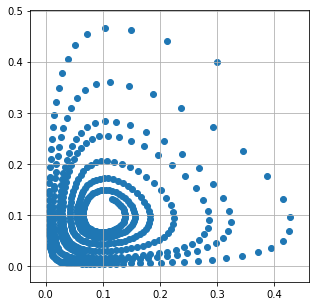

In [5]:
x_param = torch.tensor([0.3], requires_grad=True)
y_param = torch.tensor([0.4], requires_grad=True)
param_list = [[x_param], [y_param]]

alpha = 1
num_iter = 500

x_player = []
y_player = []
colors = []

def payoff_func(param_list):
    x_loss = alpha * (torch.sum(param_list[0][0]) - 0.1) * (torch.sum(param_list[1][0]) - 0.1)
    y_loss = - alpha * (torch.sum(param_list[0][0]) - 0.1) * (torch.sum(param_list[1][0]) - 0.1)
    
    return [x_loss, y_loss]

# Initialize optimizer.
optim = cmd_utils.CMD(param_list, bregman=potentials.shannon_entropy(1))

for n in range(num_iter):
    x_player.append(float(param_list[0][0].data[0]))
    y_player.append(float(param_list[1][0].data[0]))
    
    optim.step(payoff_func(param_list))
    
plt.figure(figsize=(5,5))
plt.grid()
plt.scatter(x_player, y_player)
plt.show()
